In [2]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from tqdm import tqdm
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat
from lib.datasets.mnist_fid import evaluate_fid_score
def categorical_log_likelihood(x, logits):
    """Log likelihood of a discretized Gaussian specialized for image data.

    Assumes data `x` consists of integers [0, num_classes-1].

    Args:
    x: where to evaluate the distribution. shape = (bs, ...), dtype=int32/int64
    logits: logits, shape = (bs, ..., num_classes)

    Returns:
    log likelihoods
    """
    pass
    #log_probs = nn.log_softmax(logits)
    #x_onehot = nn.one_hot(x, logits.shape[-1])
    #return torch.sum(log_probs * x_onehot, axis=-1)

In [ ]:
max_t = 0.99999
min_t = 0.01
num_steps = [50, 100, 250, 500, 750, 1000]
nfe_10_01 = []
for steps in num_steps:
    ts = np.concatenate(
        (np.
        linspace(max_t, min_t, steps), np.array([0]))
    )
    print(len(ts))
    k = 0 
    for i, t in tqdm(enumerate(ts[0:-1])):
        print(i+1)
        if t <= 0.1:
            for j in range(10):
                k += 1
                print(k)
    print(i)
    print(i+k)
    nfe_10_01.append(i+k)
print(nfe_10_01)

# nfe_1_01 = [54, 109, 272, 545, 818, 1090] 
# nfe_3_01 = [64, 129, 318, 637, 956, 1272]
# nfe_5_01 = [74, 149, 364, 729, 1094, 1454]
# nfe_10_01 = [99, 199, 479, 959, 1439, 1909]



In [ ]:

n_samples = 15 * 25
#s_name = 'Samples/mnist_unet_LBJF2000.npy'
s_name = 'Samples/MNIST/mnist_unet_corrector5_01_TauL1000.npy' # Samples/MNIST/
samples = np.load(s_name)
samples = samples[550:]
samples = samples.reshape(-1, 1, 28, 28)
#saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
fig = plt.figure(figsize=(15, 25)) 
plt.subplots_adjust(wspace=0.001, hspace=0.001)
int(np.sqrt(n_samples))
for i in range(n_samples):
    plt.subplot(int(25), int(15), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")

plt.tight_layout()  
plt.savefig('mnist_unet_corrector5_01_TauL1000.pdf', transparent=True)
plt.show()
plt.close()

In [3]:


path = 'SavedModels/MNISTHollow/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-18' # 2
config_name = 'config_001_hollow_direct.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_519999_hollow_direct.pt'

path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-25' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_599999_unet14Mlogits.pt'

path = 'SavedModels/MNISTHollow/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-03' # 2
config_name = 'config_001_hollow.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_539999_hollow.pt'

dataset_location = 'lib/datasets'

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

cfg = bookkeeping.load_config(config_path)
cfg.data.train = False
"""
if cfg.loss.name == 'CatRM':
    cfg.loss.name = 'SDDMNLL'
elif cfg.loss.name == 'CTElbo':
    cfg.loss.name = 'TauLDRNLL'
else:
    raise KeyError("Eval not defined!")

cfg.training.train_step_name = 'EvalMNIST'
"""
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)

optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}

state = bookkeeping.load_state(state, checkpoint_path)
cfg.training.n_iters = 600000 
cfg.sampler.sample_freq = 100000000
cfg.saving.checkpoint_freq = 10000
cfg.sampler.num_steps = 1000

# EvalMNIST

loss = losses_utils.get_loss(cfg)

training_step = training_utils.get_train_step(cfg)

sampler = sampling_utils.get_sampler(cfg)



print("Info:")
print("--------------------------------")
print("State Iter:", state["n_iter"])
print("--------------------------------")
print("Name Dataset:", cfg.data.name)
print("Loss Name:", cfg.loss.name)

print("--------------------------------")
print("Model Name:", cfg.model.name)
print("Number of Parameters: ", sum([p.numel() for p in model.parameters()]))

model.eval()
#66.52994572680203  # Inception mean:  7.715643802044586
# Inception std:  0.18737017997662175

self.input_embedding torch.float32
ema state dict function
D 784
Info:
--------------------------------
State Iter: 539999
--------------------------------
Name Dataset: DiscreteMNIST
Loss Name: CatRM
--------------------------------
Model Name: GaussianHollowEMA
Number of Parameters:  14082304


In [ ]:
steps = [1000]
#mjumps_rate = []
#chang_dim_all = np.empty((5, 1000))
#mjumps_all = np.empty((5, 1000))
avg_dim_1 = []
avg_dim_12 = []
avg_dim_ins = []
avg_dim_mulj = []
chang_dim = []
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
#cfg.sampler.num_steps = 10
cfg.sampler.is_ordinal = True
sampler_names = ['MidPointTauL'] # 'CRMLBJF', 
n_samples = 200
clip1 = []
clip2 = []
for _, n_name in enumerate(sampler_names):
    cfg.sampler.name = n_name 
    print("# name:", cfg.sampler.name)
    for _, n_steps in enumerate(steps):
        cfg.sampler.num_steps = n_steps
        print("# step:", cfg.sampler.num_steps)
        for i in range(50):
            
            sampler = sampling_utils.get_sampler(cfg)
            samples, changes_jump, changes_dim, change_dim_first, change_1to2, change_clamp1, change_clamp2 = sampler.sample(model, n_samples)
            saved_samples = samples
            print(f'mnist_hollow_{cfg.sampler.name}{cfg.sampler.num_steps}_mnist{i}')
            np.save(f'mnist_hollow_{cfg.sampler.name}{cfg.sampler.num_steps}_mnist{i}', saved_samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size))
        """
            if i == 0 :
                print("# Prop Multiple jumps over time", changes_jump)
                print("# change dim x to x_prime over time", change_dim_first)
                print("# change dim x_prime to x_new over time", change_1to2)
                print("# Average proportion of dim that changes over time", changes_dim)
                print("-----------------------------------------------")
                print("# Mean of multiple jumps for tau plot", np.mean(changes_jump))
                print("# FIRST: Mean of avg changing dim for tau plot", np.mean(change_dim_first))
                print("# FIRST2SECOND: Mean of avg changing dim for tau plot", np.mean(change_1to2))
                print("# Mean of avg changing dim for tau plot", np.mean(changes_dim))

            
        
        #np.save(f'MNISTstatistics/unet_mptaul{n_steps}_mjumps_prime_t.npy', changes_jump)
        #np.save(f'MNISTstatistics/unet_mptaul{n_steps}_dim_1_prime_t.npy', change_dim_first)
        #np.save(f'MNISTstatistics/unet_mptaul{n_steps}_dim_12_prime_t.npy', change_1to2)
        #np.save(f'MNISTstatistics/unet_mptaul{n_steps}_dim_ins_prime_t.npy', changes_dim)
        
        avg_dim_1.append(np.mean(change_dim_first))
        avg_dim_12.append(np.mean(change_1to2))
        avg_dim_ins.append(np.mean(changes_dim))
        avg_dim_mulj.append(np.mean(changes_jump))
        clip1.append(np.mean(change_clamp1))
        clip2.append(np.mean(change_clamp2))
        """
#np.save(f'MNISTstatistics/unet_mptaul_mjumps_tau.npy', avg_dim_mulj)
#np.save(f'MNISTstatistics/unet_mptaul_dim_1_tau.npy', avg_dim_1)
#np.save(f'MNISTstatistics/unet_mptaul_dim_12_tau.npy', avg_dim_12)
#np.save(f'MNISTstatistics/unet_mptaul_dim_ins_tau.npy', avg_dim_ins)
#np.save(f'MNISTstatistics/unet_mptaul_clip1.npy', clip1)
#np.save(f'MNISTstatistics/unet_mptaul_clip2.npy', clip2)

In [ ]:
steps = [5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 1000]
avg_dim_1 = []
avg_dim_12 = []
avg_dim_ins = []
avg_dim_mulj = []
for n_steps in steps:
    changes_jump = np.load(f'MNISTstatistics/unet_mptaul{n_steps}_mjumps_prime_t.npy')
    change_dim_first = np.load(f'MNISTstatistics/unet_mptaul{n_steps}_dim_1_prime_t.npy')
    change_1to2 = np.load(f'MNISTstatistics/unet_mptaul{n_steps}_dim_12_prime_t.npy')
    changes_dim = np.load(f'MNISTstatistics/unet_mptaul{n_steps}_dim_ins_prime_t.npy')
    avg_dim_1.append(np.mean(change_dim_first))
    avg_dim_12.append(np.mean(change_1to2))
    avg_dim_ins.append(np.mean(changes_dim))
    avg_dim_mulj.append(np.mean(changes_jump))
np.save(f'MNISTstatistics/unet_mptaul_mjumps_prime_tau.npy', avg_dim_mulj)
np.save(f'MNISTstatistics/unet_mptaul_dim_1_prime_tau.npy', avg_dim_1)
np.save(f'MNISTstatistics/unet_mptaul_dim_12_prime_tau.npy', avg_dim_12)
np.save(f'MNISTstatistics/unet_mptaul_dim_ins_prime_tau.npy', avg_dim_ins)
    

    

In [ ]:
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.1)
#cfg.sampler.num_steps = 10
cfg.sampler.is_ordinal = True
sampler_names = ['LBJF'] # 'CRMLBJF', 
n_samples = 2000
for _, n_name in enumerate(sampler_names):
    cfg.sampler.name = n_name 
    print("# name:", cfg.sampler.name)
    for pc in [3, 5, 10]:
        cfg.sampler.num_corrector_steps = pc
        print("Corrector:", cfg.sampler.num_corrector_steps)
        for _, n_steps in enumerate([50, 100, 250, 500, 750, 1000]):
            cfg.sampler.num_steps = n_steps
            print("# step:", cfg.sampler.num_steps)
            for i in range(5):
                sampler = sampling_utils.get_sampler(cfg)
                samples, changes = sampler.sample(model, n_samples)
                saved_samples = samples
                np.save(f'mnist_unet_corrector{pc}_01_{cfg.sampler.name}{cfg.sampler.num_steps}_mnist{i}', saved_samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size))


In [ ]:
steps = [1000]
corrector = 5
sampler_name = ['MidPointTauL']# , CRMTauL']
for sampler_n_i in sampler_name:
    for step in steps:
        data_list = []
        for i in range(16):
            print(f'mnist_hollow_{sampler_n_i}{step}_mnist{i}.npy')
            data_list.append(np.load(f'mnist_hollow_{sampler_n_i}{step}_mnist{i}.npy'))
        data = np.vstack(data_list)
        print(data.shape)
        np.save(f'Samples/MNIST/mnist_hollow_{sampler_n_i}{step}.npy', data)

In [26]:
steps = [500]
sampler_names = ['LBJF']# , 'CRMTauL', 'ExactSampling' ] # 'LBJF', 
c = 1
#for sampler_n_i in sampler_name:
#    for step in steps:
cfg.data.train = True
#        data = np.load(f'unet_{sampler_n_i}{step}_mnist.npy')
fid_values = []
for sampler_n in sampler_names:
    for step in steps:
        data = np.load(f'Samples/MNIST/mnist_unet_corrector{c}_01_{sampler_n}{step}.npy')
        #data = np.load('mpl_x.npy')
        print(data.shape)
        dataset = dataset_utils.get_dataset(cfg, device, dataset_location)

        dataloader = torch.utils.data.DataLoader(dataset,
            batch_size=data.shape[0],
            shuffle=cfg.data.shuffle)
        for true_data in tqdm(dataloader):
            #print(f'mnist_hollow_{sampler_n}{step}.npy')
            print("----------------------------------")
            print("Sampler:", sampler_n)
            print("Step:", step)
            fid = evaluate_fid_score(data, true_data.cpu().numpy(), 100)
            print("FID:", fid)
            fid_values.append(fid)
            break
print(fid_values)
# LBJF: 500 c1
# LBJF ab 500 c3: [65.00767287991044, 30.49072227318959, 17.539240669487356]
# LBJF ab 500 c5: [62.703384997916515, 28.830249202615704, 17.792121677059924]

(10000, 1, 28, 28)


  0%|          | 0/6 [00:00<?, ?it/s]

----------------------------------
Sampler: LBJF
Step: 500


  0%|          | 0/6 [00:18<?, ?it/s]

FID: 71.91023761024175
[71.91023761024175]


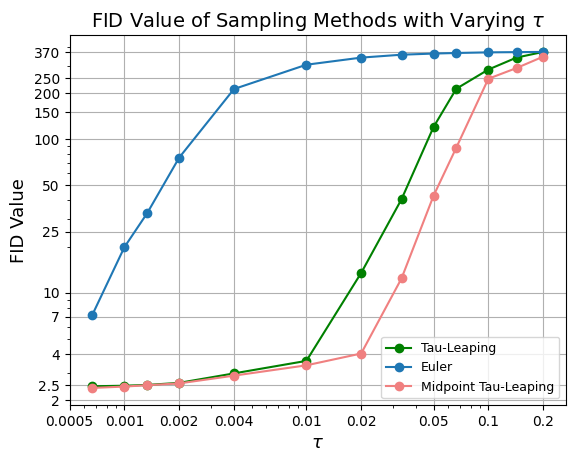

In [39]:
import numpy as np
import matplotlib.pyplot as plt
# FID
steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500, 1000, 2000]), 4)
steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 1500])
fid_taul = np.array([369.82769160402194, 339.7123739152373, 283.87526811768316, 212.90508021598973, 120.04226304249106, 40.6234648618652, 13.453524786963495, 3.6, 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.460157370950734])
fid_lbjf = np.array([369.82769160402194, 368.6921461974128, 367.43394813969206, 363.92216793023744, 360.795573791034, 354.6901690476625, 339.59518918406286, 305.2288604477556, 212.0276736955564, 75.84530505097865, 32.956622302615955, 19.817409823054646, 7.19])
fid_mpl = np.array([344.39284875166595, 290.45552043389864, 247.32958569058357, 88.0448768470724, 42.82853224434638, 12.394969584434108, 4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.5, 2.4493237174940248, 2.40])
plt.plot(steps, fid_taul, marker='o', color='green', label='Tau-Leaping')
plt.plot(steps, fid_lbjf, marker='o', label='Euler')
plt.plot(steps, fid_mpl, marker='o', label='Midpoint Tau-Leaping', color='lightcoral')
plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Sampling Methods with Varying $\\tau$', fontsize=14)
plt.legend(fontsize=9)
plt.grid(True)
plt.xscale('log')
steps_y = [370, 250, 200, 150, 100, 50, 25, 10, 7, 4, 2.5, 2]
plt.yscale('log')
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.savefig('fid_tau.pdf')
plt.show()

In [ ]:
# IS 
import numpy as np
import matplotlib.pyplot as plt
steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500, 1000, 2000]), 4)
mean_is_mpl = np.array([8.56, 8.62, 8.677, 8.7, 8.733, 8.763])
std_is_mpl = np.array([0.078, 0.1, 0.079, 0.06, 0.057, 0.075])
# 30-60, 50-100, 100-200, 250-500, 500-1000, 750, 1500

steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 1500])
print(len(steps))
mean_is_taul = np.array([2.19, 2.22, 2.708047858197907, 3.86, 4.946, 6.260149524787618, 7.725075911310337, 8.600311295819452, 8.695352062102907, 8.730387442552915, 8.76098102664333, 8.785004667417176, 8.789941441541984])
std_is_taul = np.array([0.029, 0.027, 0.035763717879784655, 0.07, 0.09223751449123928, 0.05542292679137494, 0.07471893518876059, 0.11749863261977536, 0.05961257597104094, 0.057613531976108634, 0.06736065870254852, 0.07408158674264428, 0.07343111567356189])

mean_is_lbjf = np.array([2.197, 2.1935, 2.1905016592910244, 2.21, 2.233561128867508, 2.2720786975418426, 2.3474579482515194, 2.703195286772994, 4.422914663421897, 6.212356745289218, 7.003172870037281, 7.3776977749287855, 8.086100926383237])
std_is_lbjf = np.array([0.017, 0.028, 0.016885548328526935, 0.023, 0.01655479275116797, 0.01665546477191724, 0.021260056132834024, 0.042065063979126655, 0.0653358704449712, 0.08250910888402853, 0.09807975265868278, 0.11617335996188316, 0.07638698691732632])

mean_is_mpl = np.array([2.44, 3.01, 3.92, 5.575, 6.35, 7.779, 8.56, 8.65, 8.7, 8.745, 8.763, 8.795, 8.8])
std_is_mpl = np.array([0.019, 0.0633, 0.046, 0.0665, 0.0776, 0.087, 0.078, 0.1, 0.079, 0.06, 0.075, 0.082, 0.072])
print(len(mean_is_mpl), len(mean_is_taul), len(mean_is_lbjf), len(std_is_mpl), len(std_is_taul), len(std_is_lbjf))

plt.plot(steps, mean_is_taul, marker='o', color='green', label='Tau-Leaping')
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)],
                 [mean + std for mean, std in zip(mean_is_taul, std_is_taul)],
                 alpha=0.3, color='green')
plt.plot(steps, mean_is_lbjf, marker='o', label='Euler')
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_lbjf, std_is_lbjf)],
                 [mean + std for mean, std in zip(mean_is_lbjf, std_is_lbjf)],
                 alpha=0.3)

plt.plot(steps, mean_is_mpl, marker='o', label='MidPoint Tau-Leaping', color='lightcoral')
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_mpl, std_is_mpl)],
                 [mean + std for mean, std in zip(mean_is_mpl, std_is_mpl)],
                 alpha=0.3)

plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('Inception Score', fontsize=13)
plt.title('Inception Score of Sampling Methods with Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
plt.xscale('log')
#plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('inception_score_tau.pdf')
plt.show()



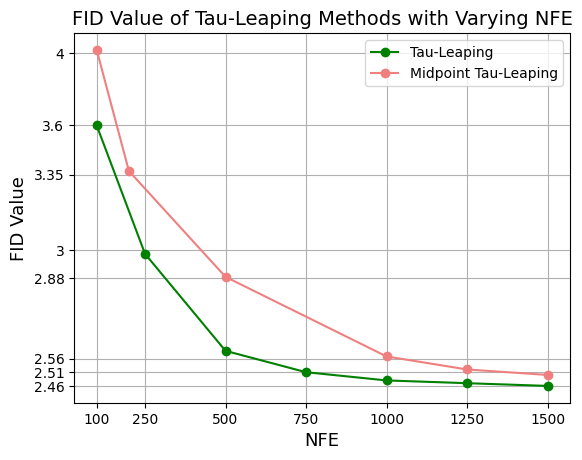

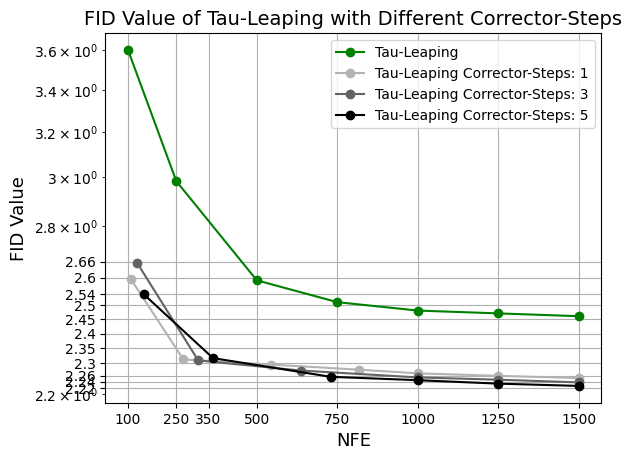

In [38]:
# NFE FID

import numpy as np
import matplotlib.pyplot as plt
"""
nfe_1_01 = [54, 109, 272, 545, 818, 1000] # 1090 last
nfe_1_01_fid = [13.172119479843474, 2.593958846497685, 2.3124636154390714,  2.2955929208740997, 2.268975460098858, 2.2571159746989906]
nfe_3_01 = [64, 129, 318, 637, 1000, 1272] # vorletzes 956
nfe_3_01_fid = [12.544362618674569, 2.653572526721007, 2.30941289542929, 2.276187915395326, 2.2539787186312788, 2.2466063307386435]
nfe_5_01 = [74, 149, 364, 729, 1000, 1500] #vorletztes 1094 letztes 15000
nfe_5_01_fid = [12.58564395129946, 2.538496664948809, 2.3170141451028314, 2.2559381898192896, 2.2450412804101074, 2.2267139529323856]
nfe_10_01 = [99, 199, 479, 1000, 1500] # vorletztes # 959 letztes 1439
nfe_10_01_fid = [11.713824326294798, 2.4731209322140444, 2.3148737019269277, 2.3065898535350584, 2.195595756357534]  #3.195595756357534
nfe_mpl = [60, 100, 200, 500, 1000, 1500]
nfe_taul = [50, 100, 250, 500, 750, 1000, 1500]
steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 2000])
fid_taul = np.array([13.453524786963495, 3.6, 2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.460157370950734])
fid_mpl = np.array([12.394969584434108, 4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.48])
                                    # 30 (60), 50 (100), 100 (200), 250 (500), 500 (1000), 750 (1500)
"""

# nfe plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
nfe_1_01 = [109, 272, 545, 818, 1000, 1250, 1500] # 1090 last
nfe_1_01_fid = [2.593958846497685, 2.3124636154390714,  2.2955929208740997, 2.278975460098858, 2.2671159746989906, 2.259, 2.252]
nfe_3_01 = [129, 318, 637, 1000, 1250, 1500] # vorletzes 956 # 1272
nfe_3_01_fid = [2.653572526721007, 2.30941289542929, 2.276187915395326, 2.2539787186312788, 2.2466063307386435, 2.238]
nfe_5_01 = [149, 364, 729, 1000, 1250, 1500] #vorletztes 1094 letztes 15000
nfe_5_01_fid = [ 2.538496664948809, 2.3170141451028314, 2.2559381898192896, 2.2450412804101074, 2.234, 2.2267139529323856]
nfe_10_01 = [199, 479, 1000, 1250, 1500] # vorletztes # 959 letztes 1439
nfe_10_01_fid = [2.4731209322140444, 2.3148737019269277, 2.3065898535350584, 2.25, 2.195595756357534]  #3.195595756357534
nfe_mpl = [100, 200, 500, 1000, 1250, 1500]
nfe_taul = [100, 250, 500, 750, 1000, 1250, 1500]

# steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 2000])
fid_taul = np.array([3.6, 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.47, 2.460157370950734])
fid_mpl = np.array([4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.52, 2.5])
"""
steps = 1 / np.array([5, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 1500])
nfe_taul = [10, 20, 30, 50, 100, 250, 500, 750, 1000, 1500]
fid_taul = np.array([283.87526811768316, 212.90508021598973, 120.04226304249106, 40.6234648618652, 13.453524786963495, 3.6, 2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.460157370950734])
nfe_mpl = [10, 20, 30, 40, 60, 100, 200, 500, 1000, 1500]
fid_taul = np.array([283.87526811768316, 120.04226304249106, 40.6234648618652, 13.453524786963495, 3.6, 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.460157370950734])
fid_mpl = np.array([344.39284875166595, 247.32958569058357, 88.0448768470724, 42.82853224434638, 12.394969584434108, 4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.5])
"""
#steps_plot = 

plt.plot(nfe_taul, fid_taul, marker='o', color='green', label='Tau-Leaping')
plt.plot(nfe_mpl, fid_mpl, marker='o', label='Midpoint Tau-Leaping', color='lightcoral')
#plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping C1')
#plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping C3')
#plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping C5')
#plt.plot(nfe_10_01, nfe_10_01_fid, marker='o', label='Tau-Leaping C10')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping Methods with Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)

steps_y = [4, 3.6, 3.35, 3, 2.88, 2.56, 2.51, 2.46]
steps_plot = [100, 250, 500, 750, 1000, 1250, 1500]
plt.yscale('log')
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
#
plt.savefig('fid_nfe_mp_taul.pdf')
plt.show()


plt.plot(nfe_taul, fid_taul, marker='o', color='green', label='Tau-Leaping')
#plt.plot(nfe_mpl, fid_mpl, marker='o', label='Midpoint Tau-Leaping')
colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben

plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2])
plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1])
plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0])

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping with Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [2.66, 2.6, 2.54, 2.5, 2.45, 2.4, 2.35, 2.30, 2.26, 2.24, 2.22]
steps_plot = [100, 250, 350, 500, 750, 1000, 1250, 1500]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
#plt.savefig('fid_tau_corrector.pdf')
plt.show()

In [ ]:
# NFE IS
mean_is_taul = np.array([8.600311295819452, 8.695352062102907, 8.730387442552915, 8.76098102664333, 8.785004667417176, 8.787, 8.789941441541984])
std_is_taul = np.array([0.11749863261977536, 0.05961257597104094, 0.057613531976108634, 0.06736065870254852, 0.07408158674264428, 0.056, 0.07343111567356189])

mean_is_mpl = np.array([8.56, 8.65, 8.7, 8.745, 8.753, 8.763])
std_is_mpl = np.array([0.078, 0.1, 0.079, 0.06, 0.057, 0.075])
#50-100, 100-200, 250-500, 500-1000, 750, 1500

steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 1500])

nfe_mpl = [100, 200, 500, 1000, 1250, 1500]
nfe_taul = [100, 250, 500, 750, 1000, 1250, 1500]

plt.plot(nfe_taul, mean_is_taul, marker='o', color='green', label='Tau-Leaping')
#plt.fill_between(nfe_taul, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)],[mean + std for mean, std in zip(mean_is_taul, std_is_taul)],alpha=0.3, color='green')

plt.plot(nfe_mpl, mean_is_mpl, marker='o', label='MidPoint Tau-Leaping', color='lightcoral')
#plt.fill_between(nfe_mpl, [mean - std for mean, std in zip(mean_is_mpl, std_is_mpl)],[mean + std for mean, std in zip(mean_is_mpl, std_is_mpl)],alpha=0.3)

plt.xlabel('NFE', fontsize=13)
plt.ylabel('Inception Score', fontsize=13)
plt.title('Inception Score of Tau-Leaping Methofs with Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)
steps_plot = [100, 250, 500, 750, 1000, 1250, 1500]
steps_y = [8.56, 8.6,8.65, 8.7, 8.74, 8.76, 8.79]
#plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.yticks(steps_y, steps_y)
plt.savefig('inception_score_mp_tau.pdf')
plt.show()

nfe_1_01 = [54, 109, 272, 545, 818, 1000] # 1090 last
nfe_3_01 = [64, 129, 318, 637, 1000, 1272] # vorletzes 956
nfe_5_01 = [74, 149, 364, 729, 1000, 1500] #vorletztes 1094 letztes 15000
nfe_10_01 = [99, 199, 479, 1000, 1500] # vorletztes # 959 letztes 1439

mean_c1 = [7.685214153332941, 8.647939466433439, 8.755318814855267, 8.728635327016125, 8.769999551759987, 8.776702214194092]
std_c1 = [0.10020794506473688, 0.12287807651939232, 0.08248251060547318, 0.08304519492126802, 0.06759433319038019, 0.12659895249777367]

mean_c3 = [7.762886743437322, 8.596458341030935, 8.798446691296359, 8.751792345723775, 8.76805730506273, 8.74081231601401]
std_c3 = [0.11598291894202396, 0.09363631101316408, 0.10748087401514818, 0.09812815045935029, 0.05775935607353134, 0.09677611504981143]

mean_c5 = [7.665914862629701, 8.659614704761324, 8.795426848297684, 8.721246193397805, 8.74803374634143, 8.744422635144518]
std_c5 = [0.10402757843947735, 0.09600572858682611, 0.062457741056709454, 0.07043536838850206, 0.10784576786370587, 0.09917689867200492]

mean_c10 = [7.737014645693776, 8.671485752113487, 8.78130387956802, 8.763744669389167, 8.662650644054375]
std_c10 = [0.09972477960311658, 0.08709899412509303, 0.0974413469033469, 0.0987803915058357, 0.10316599969779615]

"""
plt.plot(steps, mean_is_taul, marker='o', color='green', label='Tau-Leaping')
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)],
                 [mean + std for mean, std in zip(mean_is_taul, std_is_taul)],
                 alpha=0.3, color='green')

plt.plot(steps, mean_is_mpl, marker='o', label='MidPoint Tau-Leaping', color='lightcoral')
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_mpl, std_is_mpl)],
                 [mean + std for mean, std in zip(mean_is_mpl, std_is_mpl)],
                 alpha=0.3)

plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('Inception Score', fontsize=13)
plt.title('Inception Score of Sampling Methods with Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
plt.xscale('log')
#plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('inception_score_tau.pdf')
plt.show()
"""

In [ ]:
# LBJF: 500 c1
# LBJF ab 500 c3: [65.00767287991044, 30.49072227318959, 17.539240669487356]
# LBJF ab 500 c5: [62.703384997916515, 28.830249202615704, 17.792121677059924]